### Imports

In [2]:
# encoding: UTF-8

import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
from prediction.loader import read_income_data

from prediction.algo import get_predictions
from prediction.algo import get_regressor
from prediction.algo import get_metrics
from prediction.algo import get_feature_importance
from prediction.algo import get_confusion_matrix

from sklearn.metrics import classification_report

plt.rcParams['figure.figsize'] = (12.0, 8.0)

### Load the data
#### and split the features from the target

In [3]:
df = read_income_data(dummies=True)
target = df.pop('income')
features = df

### Run 30 KFold cross validation for each algorithm

In [5]:
clf_rf = get_regressor('random_forest')
p_rf = get_predictions(clf_rf, features, target)
fpr_rf, tpr_rf, t_rf, ps_rf, auc_rf = get_metrics(target, p_rf)

clf_gbr = get_regressor('gradient_boosting')
p_gbr = get_predictions(clf_gbr, features, target)
fpr_gbr, tpr_gbr, t_gbr, ps_gbr, auc_gbr = get_metrics(target, p_gbr)

clf_lin = get_regressor('linear')
p_lin = get_predictions(clf_lin, features, target)
fpr_lin, tpr_lin, t_lin, ps_lin, auc_lin = get_metrics(target, p_lin)

### Create a simple aggregation of the previous 3 algorithms

In [6]:
p_eclf = [np.mean([p_rf[i], p_gbr[i], p_lin[i]]) for i in range(0, len(p_rf))]
fpr_eclf, tpr_eclf, t_eclf, ps_eclf, auc_eclf = get_metrics(target, p_eclf)

### Plot the ROC curve

#### We add for each line the AUC (area under the curve) to describe the general accuracy of the algorithm and the PS (precision score) which is the average precision score, ie. the probability of being correct when predicting 1.0 (>50k)

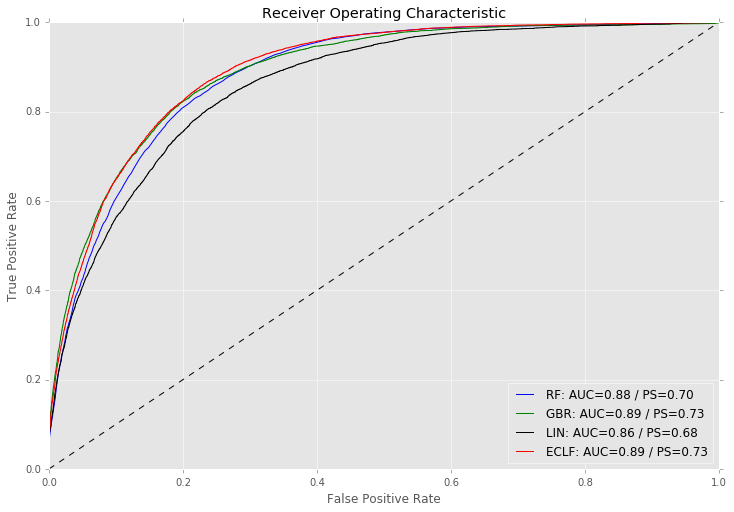

In [7]:
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'b',
label='RF: AUC=%0.2f / PS=%0.2f'% (auc_rf,  ps_rf))
plt.plot(fpr_gbr, tpr_gbr, 'g',
label='GBR: AUC=%0.2f / PS=%0.2f'% (auc_gbr,  ps_gbr))
plt.plot(fpr_lin, tpr_lin, 'k',
label='LIN: AUC=%0.2f / PS=%0.2f'% (auc_lin, ps_lin))
plt.plot(fpr_eclf, tpr_eclf, 'r',
label='ECLF: AUC=%0.2f / PS=%0.2f'% (auc_eclf, ps_eclf))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### The gradient boosting and the aggregated mean predictions have similar results confirmed by the metrics below. The difficulty to compare confusion matrix is to find the "optimal" threshold for each algorithm.

In [38]:
get_confusion_matrix(target, np.array(p_eclf), 0.45, normalize=False)

,0,1
0,22881,3360
1,1839,4481


In [47]:
print classification_report(target, (np.array(p_eclf) >= 0.45))

             precision    recall  f1-score   support

        0.0       0.87      0.93      0.90     24720
        1.0       0.71      0.57      0.63      7841

avg / total       0.83      0.84      0.83     32561



In [48]:
get_confusion_matrix(target, p_gbr, 0.45, normalize=False)

,0,1
0,19803,1398
1,4917,6443


In [50]:
print classification_report( (p_gbr >= 0.45), target)

             precision    recall  f1-score   support

      False       0.94      0.86      0.90     26779
       True       0.54      0.73      0.62      5782

avg / total       0.87      0.84      0.85     32561



#### When varying the threshold, the classification report shows us that it is difficult to find a good value for the precision and the recall. In our problem it is not specify which class is more important to detect, so instead of increasing the precision or the recall we will maximise the f-score (2 x (precision x recall) / (precision + recall))

#### We can have a glimpse at the feature importance to see if our exploratory guesses were true

### Feature importance

In [59]:
feature_importance = get_feature_importance(clf_gbr, features, target)

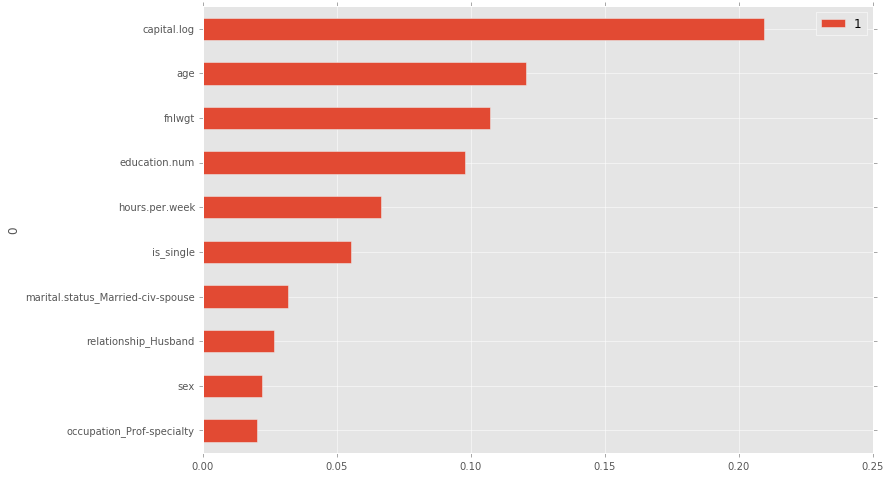

In [77]:
top10 = feature_importance.head(10).set_index(0).sort_values(1,ascending=True)
top10.plot(kind='barh')
plt.show()

As expected the **capital**, the **age** and the **education.num** are very important to the regressor. The **fnlwgt** which describe the representativity of the person (the number of US citizen with the same characteristics) has a major importance in the predictions.  It could interesting to examine closer this feature to understand and exploit it more.

### Parameters

#### We chose the number of estimators to limit the time of computation and keep good accuracy (in our case 200)

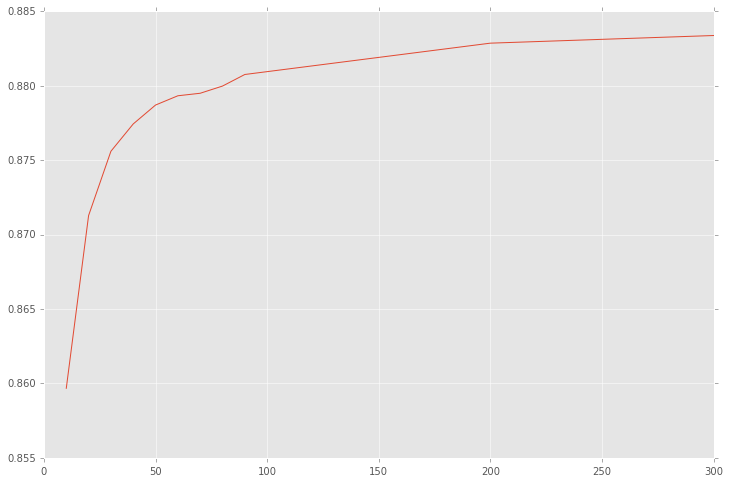

In [78]:
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 200, 300]
aucs = [0.8596695797420331,
 0.8712791297218297,
 0.8756010745937977,
 0.8774370178494999,
 0.8787071571966953,
 0.8793298616227291,
 0.8794988477503323,
 0.8799824969901385,
 0.8807605286336159,
 0.8828656181989204,
 0.88337921127803443]
plt.plot(n_estimators, aucs)
plt.show()